# HWRS 528 IMP05
## Uncertainty Analysis
### 1. Import Python packages

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import LRC_subprograms as lrc

### 2. Load data, choose time period, and specify model parameters

In [35]:
#==== Load Leaf River Catchment Data as a DataFrame ===============================
LRData = pd.read_csv('../LeafRiverDaily.csv')

#==== Get a number of datapoints ==================================================
Ndata = LRData.shape[0]
Nvars = LRData.shape[1]

#==== Choose a simulation time period and set up time vector ======================
Period_Start = 0; Period_End = 365*3                # select time period to work with
Time = np.arange(0, Period_End, 1)
NTime = len(Time)

#==== Set number of initial time steps to use as spin-up ==========================
# Metrics are not computed on this period
SpinUp = 90                                         # select 90-day spin-up period

#==== Get data for the desired period =============================================
PPobs = LRData.PP[Time].to_numpy()                  # Convert from DataFrame to numpy
PEobs = LRData.PE[Time].to_numpy()                  # arrays to avoid indexing issues
QQobs = LRData.QQ[Time].to_numpy()

#==== Determine max values for each variable ======================================
PPobs_max = np.max(PPobs)
PEobs_max = np.max(PEobs)
QQobs_max = np.max(QQobs)

#==== Specify model parameters ====================================================
NRes = 2; ResIdex = np.arange(0, NRes, 1)

### 3. Monte Carlo parameter value generation

##### 3.1 Create Monte Carlo Generator subprograms

In [36]:
#==== Monte Carlo Parameter Value Generator (for one parameter) =====================================
def ParGenerator(Bounds, NValues, seed):
    
    #==== Define upper and lower bounds from input ==================================================
    LowerBound = Bounds[0]; UpperBound = Bounds[1]

    #==== Initialize list and MCA components ========================================================
    ParValues = []              # List to hold generated parameter values
    random.seed(seed)           # Seed random number generator
    currentRoll = 1             # counter for Monte Carlo generator

    #==== Run Monte Carlo and generate parameter values =============================================
    while currentRoll <= NValues:
        r = random.random()                                     # Random number between [0,1]
        ParValue = LowerBound + (UpperBound-LowerBound) * r     # generate parameter value between bounds
        ParValues.append(ParValue)                              # add parameter value to list

        currentRoll += 1

    return ParValues

#==== Compile list of Monte Carlo-generated parameter value lists ====================================
def ParList(ParBounds, NValues):
    NPars  = len(ParBounds)                                     # Number of parameters to generate values
    ParIdx = np.arange(0, NPars, 1)
    ParValueList = []                                           # List to hold lists of parameter values

    for i in ParIdx:
        seed = random.randint(0, 1000)                          # Random seed for each ParGenerator iteration
        Bounds = ParBounds[i]                                   # Set bounds for each parameter
        ParValues = ParGenerator(Bounds, NValues, seed)         # Run ParGenerator_fun to create list of parameter values
        ParValueList.append(ParValues)                          # Compile list of parameter value lists

    return ParValueList

#==== Compile list of parameter sets ================================================================
def ParSets(ParBounds, NValues):
    ParValueList = ParList(ParBounds, NValues)                  # Run ParList_fun to generate list of parameter values\
                                                                # for each parameter.
    Par1 = ParValueList[0]; Par2 = ParValueList[1]; Par3 = ParValueList[2]  # Separate ParValueList into one list for\
    Par4 = ParValueList[3]; Par5 = ParValueList[4]; Par6 = ParValueList[5]  # each parameter (six total lists).

    ParSetList = []                                             # List to hold MC-generated parameter sets
    ParSetIdx = np.arange(0, NValues, 1)

    for i in ParSetIdx:
        ParSet = [Par1[i], Par2[i], Par3[i],                    # Create parameter set by pulling nth element from\
                  Par4[i], Par5[i], Par6[i]]                    # parameter value lists
        ParSetList.append(ParSet)                               # Compile list of parameter sets
    
    return ParSetList

##### 3.2 Generate random parameter sets

In [51]:
#==== Set number of iterations ==========================================
NValues = 1000

#==== Set paramter bounds ===============================================
            # Theta_C1  Theta_P1  Theta_K12  Theta_K13   Theta_K2Q    Theta_K3Q
ParBounds = [[10,300], [0.5,1.5], [0.0,0.5], [0.0,0.9], [0.0001,0.1], [0.1,0.9]]

ParSetList = ParSets(ParBounds, NValues)

### 4. MC-generated model running and analysis
##### 4.1 Run model for NValues iterations and compile results

In [52]:
NParSets   = len(ParSetList)
ParSetsIdx = np.arange(0, NParSets, 1)

QQsimList = []; MSEList   = []; NSEList  = []
KGEssList = []; alphaList = []; betaList = []
rhoList   = []

for i in ParSetsIdx:
    Pars = ParSetList[i]
    [QQsim, AEsim, MSE,NSE,NSEL,KGEss,KGE,alpha,beta,rho] = lrc.MainCatchModel(Pars, PPobs, PEobs, QQobs, NRes)

    QQsimList.append(QQsim); MSEList.append(MSE); NSEList.append(NSE)
    KGEssList.append(KGEss); alphaList.append(alpha); betaList.append(beta)
    rhoList.append(rho)
    
#~~~~~~~~~~~~~~~~~~~~~~~~ FYI: 1_000 model runs took 1m 3.6s ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

##### 4.2 Analyze MC-generated model results

In [72]:
#==== Calculate the 0.5 and 0.95 quantiles for streamflow values from MC-generated parameter values =========
QQ_95_quantile = np.quantile(QQsimList, 0.95, axis=0, keepdims=True)[0]
QQ_05_quantile = np.quantile(QQsimList, 0.05, axis=0, keepdims=True)[0]

##### 4.3 Generate diagnostic plots

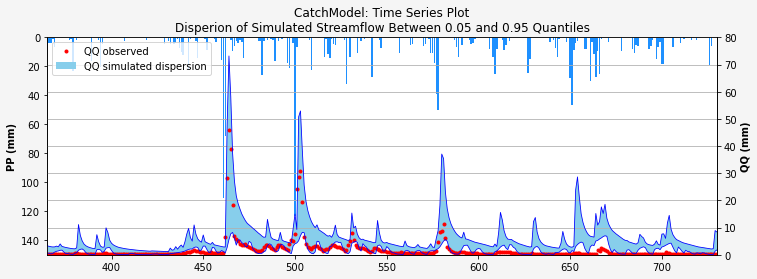

In [101]:
#==== Plot streamflow timeseries with 0.5 and 0.95 dispersion ======================================
WY1950_Start = 365; WY1950_End = 731; WY1950 = np.arange(WY1950_Start, WY1950_End, 1)

QQobs1950 = QQobs[WY1950_Start:WY1950_End]; PPobs1950 = PPobs[WY1950_Start:WY1950_End]
QQ_95 = np.transpose(QQ_95_quantile[WY1950_Start:WY1950_End])
QQ_05 = np.transpose(QQ_05_quantile[WY1950_Start:WY1950_End])

fig, ax1 = plt.subplots(squeeze=True, facecolor='whitesmoke', figsize=(12,4))

ax1.bar(WY1950, PPobs1950, label='PP observed', color='dodgerblue')
ax1.set_ylabel('PP (mm)', fontweight='bold')
ax1.set_ylim(0,150)
ax1.invert_yaxis()

ax2 = ax1.twinx()

ax2.plot(WY1950, QQobs1950, 'or', label='QQ observed', markersize=3)
ax2.plot(WY1950, QQ_95, '-b', linewidth=0.8)
ax2.plot(WY1950, QQ_05, '-b', linewidth=0.8)
ax2.fill_between(WY1950, QQ_95, QQ_05, facecolor='skyblue', label='QQ simulated dispersion')
ax2.set_ylabel('QQ (mm)', fontweight='bold')
ax2.set_xlabel('Time (days)', fontweight='bold')
ax2.set_title('CatchModel: Time Series Plot\nDisperion of Simulated Streamflow Between 0.05 and 0.95 Quantiles')
ax2.grid('--k')
ax2.set_xlim(WY1950_Start, WY1950_End-1)
ax2.set_ylim(0,80)
ax2.legend(loc=2)

plt.show()